# NER Coding Challenge
### In any text document, there are particular terms that represent specific entities that are more informative and have a unique context. These entities are known as named entities , which more specifically refer to terms that represent real-world objects like people, places, organizations, and so on, which are often denoted by proper names. A naive approach could be to find these by looking at the noun phrases in text documents. Named entity recognition (NER) , also known as entity chunking/extraction , is a popular technique used in information extraction to identify and segment the named entities and classify or categorize them under various predefined classes.

# Overview of what has been implemented

*   Data Exploration
*   Simple classifiers - Perceptron, SGD Classifier, Multinomial Naive bayes
*   Character based LSTM
*   ELMO based residual LSTM
*   Bonus question - Confidence score for predictions



## 1 - Load the given training dataset

In [0]:
import pandas as pd
train_data = pd.read_csv("train.txt", sep="\t", header=None,names=["Name", "Tag"])

## 1.1 - Understand what's there in the data - Exploratory Data Analysis
 First, the data is loaded into a Pandas DataFrame. This can be done easily using the read_csv function, specifying that the separator is a tab space.

In [2]:
train_data.head()

,Name,Tag
0,@paulwalk,O
1,It,O
2,'s,O
3,the,O
4,view,O


### Are there any NaN rows? If yes, remove them.


In [3]:
nan_rows = train_data[train_data['Name'].isnull()]
print("Number of Nan rows is %d" %(len(nan_rows)))

Number of Nan rows is 2168


In [4]:
train_data = train_data.dropna()
print("New training data length is %d" %(len(train_data)))

New training data length is 55725


### What are the entity tags?

[['O', 52997], ['B-person', 566], ['B-location', 494], ['I-person', 288], ['B-group', 230], ['I-location', 226], ['B-corporation', 196], ['I-product', 163], ['I-creative-work', 150], ['I-group', 132], ['B-product', 130], ['B-creative-work', 110], ['I-corporation', 43]]


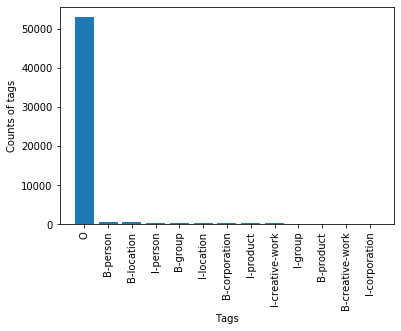

In [5]:
tags_list = train_data.Tag.value_counts().reset_index().values.tolist()
print(tags_list)
import matplotlib.pyplot as plt
tag_vals = [i[0] for i in tags_list]
counts = [i[1] for i in tags_list]
plt.bar(range(0,len(tag_vals)),counts)
plt.xticks(range(0,len(tag_vals)), tag_vals, rotation='vertical')
plt.xlabel("Tags")
plt.ylabel("Counts of tags")
plt.show()

We see that the tags are in "BIO" format. BIO stands for Beginning, Inside and Outside (of a text segment). In a system that recognizes entity boundaries only, only three labels are used: B, I and O. What is also understood from the above output is that the tags are not evenly distributed. Since the class 'O' is more than the rest, we shall neglect it and make use of the remaining tags.

[['B-person', 566], ['B-location', 494], ['I-person', 288], ['B-group', 230], ['I-location', 226], ['B-corporation', 196], ['I-product', 163], ['I-creative-work', 150], ['I-group', 132], ['B-product', 130], ['B-creative-work', 110], ['I-corporation', 43]]


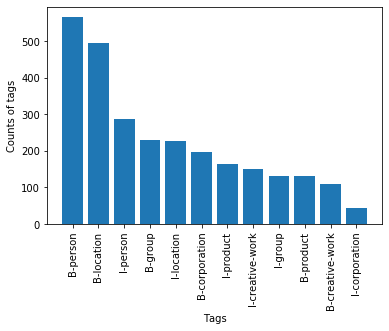

In [6]:
tags_list.pop(0)
print(tags_list)
tag_vals = [i[0] for i in tags_list]
counts = [i[1] for i in tags_list]
plt.bar(range(0,len(tag_vals)),counts)
plt.xticks(range(0,len(tag_vals)), tag_vals, rotation='vertical')
plt.xlabel("Tags")
plt.ylabel("Counts of tags")
plt.show()

### What else is present in the dataset?


In [0]:
from collections import namedtuple, defaultdict
Tag = namedtuple("Tag", ["token", "tag"])
def load_sequences(filename, sep="\t", notypes=False):
    tag_count = defaultdict(int)
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                if notypes:
                    line[1] = line[1][0]
                tag_count[line[1]] += 1
                #print line
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences, tag_count
sequences, tag_count = load_sequences("train.txt", sep="\t")

In [0]:
import re
URL_REGEX = re.compile(r'^http[s]?://')
assert URL_REGEX.match("http://Google.com") is not None
assert URL_REGEX.match("https://Google.com") is not None
assert URL_REGEX.match("abchttps://Google.com") is None
REPEATED_CHAR_REGEX=re.compile(r'^[\.\,!\?"\':;_\-]{2,}$')
assert REPEATED_CHAR_REGEX.match("!") is None
assert REPEATED_CHAR_REGEX.match("!!") is not None
assert REPEATED_CHAR_REGEX.match("!?...!") is not None
assert REPEATED_CHAR_REGEX.match('".') is not None
assert REPEATED_CHAR_REGEX.match("aaaaa") is None
assert REPEATED_CHAR_REGEX.match('\".') is not None
WORD_REGEX=re.compile(r'^([A-Za-z]+[\'\-\.]?)+$')
assert WORD_REGEX.match("ABC") is not None
assert WORD_REGEX.match("ABC-D") is not None
assert WORD_REGEX.match("ABC'D") is not None
assert WORD_REGEX.match("ABC.DFC.") is not None
assert WORD_REGEX.match("9-1") is None
assert WORD_REGEX.match("A.B.C") is not None
NUMBER_REGEX=re.compile(r'^(([0-9]*[.]?[0-9]+)|([0-9]+[,]?[0-9]+))$')
assert NUMBER_REGEX.match("123") is not None
assert NUMBER_REGEX.match("123,4") is not None
assert NUMBER_REGEX.match("12.5") is not None
assert NUMBER_REGEX.match(".5") is not None
assert NUMBER_REGEX.match("12-A") is None
assert NUMBER_REGEX.match(",55") is None
assert NUMBER_REGEX.match("5.5.55") is None

In [9]:
def get_token_type(t):
    if len(t.token) > 1 and t.token[0] in ['\'', '\"', '(', '-']:
        return get_token_type(Tag(t.token[1:], t.tag))
    if len(t.token) > 1 and t.token[0] == "@":
        return "Mentions (@___)"
    if len(t.token) > 1 and t.token[0] == "#":
        return "Hashtags"
    if len(t.token) > 1 and t.token[0] == "$":
        return "Money ($$)"
    if URL_REGEX.match(t.token):
        return "URLs"
    if NUMBER_REGEX.match(t.token):
        return "Numbers"
    if WORD_REGEX.match(t.token):
        return "Words"
    if t.token.isalnum():
        return "Alphanumeric characters"
    if REPEATED_CHAR_REGEX.match(t.token):
        return "Repeated characters (...)"
    return "Other"

from collections import Counter, OrderedDict
pd.DataFrame(Counter(get_token_type(t) for seq in sequences for t in seq).most_common(), columns=["Type", "Counts"])

,Type,Counts
0,Words,48016
1,Other,8036
2,Mentions (@___),1961
3,Repeated characters (...),1229
4,Numbers,1218
5,URLs,955
6,Hashtags,826
7,Alphanumeric characters,459
8,Money ($$),30


## 2 - Using basic algorithms like Perceptron, SGD classifier, Multinomial Naive Bayes classifier

### Transform the given data into operable form using DictVectorizer. Use a 67-33 split to generate a dev set

In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
X = train_data.drop('Tag', axis=1)
v = DictVectorizer(sparse=False)
X = v.fit_transform(X.to_dict('records'))
y = train_data.Tag.values

classes = np.unique(y)
classes = classes.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)
print(X_train.shape, y_train.shape)

(37335, 13794) (37335,)


#### Load the libraries for the classifiers

In [0]:
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

### 2.1 Perceptron

In [12]:
per = Perceptron(verbose=10, n_jobs=-1, max_iter=5)
per.partial_fit(X_train, y_train, classes)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1


Norm: 14.80, NNZs: 170, Bias: -1.000000, T: 37335, Avg. loss: 0.002437
Total training time: 1.23 seconds.
-- Epoch 1
Norm: 10.15, NNZs: 94, Bias: -1.000000, T: 37335, Avg. loss: 0.002330
Total training time: 1.38 seconds.
Norm: 17.06, NNZs: 259, Bias: -1.000000, T: 37335, Avg. loss: 0.004741-- Epoch 1

Total training time: 1.40 seconds.
-- Epoch 1
Norm: 24.84, NNZs: 518, Bias: -1.000000, T: 37335, Avg. loss: 0.008785
Total training time: 1.42 seconds.
-- Epoch 1
Norm: 27.00, NNZs: 617, Bias: -1.000000, T: 37335, Avg. loss: 0.009214
Total training time: 1.29 seconds.
-- Epoch 1
Norm: 6.71, NNZs: 39, Bias: -1.000000, T: 37335, Avg. loss: 0.000857
Norm: 10.77, NNZs: 99, Bias: -2.000000, T: 37335, Avg. loss: 0.003589Total training time: 1.28 seconds.
Total training time: 1.27 seconds.

-- Epoch 1
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.5s


Norm: 13.15, NNZs: 149, Bias: -1.000000, T: 37335, Avg. loss: 0.002303
Total training time: 1.44 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed:    2.8s remaining:    1.8s


Norm: 10.15, NNZs: 97, Bias: -1.000000, T: 37335, Avg. loss: 0.002973
Total training time: 1.40 seconds.
-- Epoch 1
Norm: 18.63, NNZs: 305, Bias: -1.000000, T: 37335, Avg. loss: 0.005277
Total training time: 1.28 seconds.
Norm: 15.75, NNZs: 221, Bias: -2.000000, T: 37335, Avg. loss: 0.004071
Total training time: 1.38 seconds.
Norm: 13.30, NNZs: 163, Bias: -1.000000, T: 37335, Avg. loss: 0.003589
Total training time: 1.26 seconds.


[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    4.0s remaining:    1.2s


Norm: 57.73, NNZs: 2645, Bias: 1.000000, T: 37335, Avg. loss: 0.045909
Total training time: 0.88 seconds.


[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    4.8s finished


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=5, n_iter_no_change=5, n_jobs=-1,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=10, warm_start=False)

#### Evaluating the classification metric without the Tag 'O'

In [13]:
new_classes = classes.copy()
new_classes.pop()
print(classification_report(y_pred=per.predict(X_test), y_true=y_test, labels=new_classes))

                 precision    recall  f1-score   support

  B-corporation       0.69      0.36      0.47        67
B-creative-work       0.40      0.10      0.16        41
        B-group       0.42      0.15      0.22        68
     B-location       0.73      0.28      0.40       165
       B-person       0.72      0.28      0.41       186
      B-product       0.47      0.18      0.26        38
  I-corporation       0.00      0.00      0.00        16
I-creative-work       0.00      0.00      0.00        53
        I-group       0.25      0.12      0.16        51
     I-location       0.60      0.04      0.07        83
       I-person       0.67      0.17      0.27        93
      I-product       0.59      0.20      0.29        51

      micro avg       0.61      0.20      0.30       912
      macro avg       0.46      0.16      0.23       912
   weighted avg       0.57      0.20      0.28       912



### 2.2 SGD Classifier

In [14]:
sgd = SGDClassifier()
sgd.partial_fit(X_train, y_train, classes)
print(classification_report(y_pred=sgd.predict(X_test), y_true=y_test, labels=new_classes))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

  B-corporation       1.00      0.27      0.42        67
B-creative-work       0.00      0.00      0.00        41
        B-group       0.00      0.00      0.00        68
     B-location       0.86      0.04      0.07       165
       B-person       0.83      0.10      0.18       186
      B-product       1.00      0.05      0.10        38
  I-corporation       0.00      0.00      0.00        16
I-creative-work       0.00      0.00      0.00        53
        I-group       0.00      0.00      0.00        51
     I-location       0.00      0.00      0.00        83
       I-person       0.83      0.05      0.10        93
      I-product       0.00      0.00      0.00        51

      micro avg       0.89      0.05      0.10       912
      macro avg       0.38      0.04      0.07       912
   weighted avg       0.52      0.05      0.10       912



### 2.3 Multinomial Naive Bayes Classifier

In [15]:
nb = MultinomialNB(alpha=0.01)
nb.partial_fit(X_train, y_train, classes)
print(classification_report(y_pred=nb.predict(X_test), y_true=y_test, labels = new_classes))

                 precision    recall  f1-score   support

  B-corporation       0.90      0.39      0.54        67
B-creative-work       0.33      0.02      0.05        41
        B-group       0.50      0.15      0.23        68
     B-location       0.77      0.26      0.39       165
       B-person       0.68      0.25      0.37       186
      B-product       0.70      0.18      0.29        38
  I-corporation       0.00      0.00      0.00        16
I-creative-work       0.00      0.00      0.00        53
        I-group       0.38      0.06      0.10        51
     I-location       0.42      0.12      0.19        83
       I-person       0.67      0.19      0.30        93
      I-product       0.60      0.18      0.27        51

      micro avg       0.66      0.19      0.30       912
      macro avg       0.49      0.15      0.23       912
   weighted avg       0.59      0.19      0.29       912



While the precision values are somewhat is the acceptable range, the recall values are very poor and so is their harmonic mean - F1-score. None of the above classifiers produced satisfying results. It is obvious that it is not going to be easy to classify named entities using regular classifiers.

## 3 - Using Conditional Random Fields
#### Conditional random fields (CRFs) are a class of statistical modeling method often applied in pattern recognition and machine learning and used for structured prediction. CRFs is often used for labeling or parsing of sequential data, such as natural language processing and CRFs find applications in POS Tagging, named entity recognition, among others.

#### Load the data as a list 

In [0]:
train_data_list = train_data.values.tolist()

### Perform POS tagging for every token in the dataset

In [17]:
import nltk
import numpy as np
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
data = []
for i, doc in enumerate(train_data_list):
    docs = [(doc[0],doc[1])]
    tokens = [doc[0]]
    tagged = nltk.pos_tag(tokens)
    data.append([(w, pos, label) for (w, label), (word, pos) in zip(docs, tagged)])

#### How this data variable looks after POS tagging

In [19]:
data[:10]

[[('@paulwalk', 'NN', 'O')],
 [('It', 'PRP', 'O')],
 [("'s", 'POS', 'O')],
 [('the', 'DT', 'O')],
 [('view', 'NN', 'O')],
 [('from', 'IN', 'O')],
 [('where', 'WRB', 'O')],
 [('I', 'PRP', 'O')],
 [("'m", 'VBP', 'O')],
 [('living', 'NN', 'O')]]

### Begin training on the CRFsuite

In [20]:
!pip install sklearn_crfsuite

In [0]:
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import metrics

#### I will extract more features in the crfsuite format (word parts, simplified POS tags, lower/title/upper flags, features of nearby words)

In [0]:
def word2features(doc, i):
    word = doc[i][0]
    postag = doc[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag
    ]

    # Features for words that are not
    # at the beginning of a document
    if i > 0:
        word1 = doc[i-1][0]
        postag1 = doc[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:word.isdigit=%s' % word1.isdigit(),
            '-1:postag=' + postag1
        ])
    else:
        features.append('BOS')  #Beginning of a sentence
    # If we have features at the beginning of a sentence
    if i < len(doc)-1:
        word1 = doc[i+1][0]
        postag1 = doc[i+1][1]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:word.isdigit=%s' % word1.isdigit(),
            '+1:postag=' + postag1
        ])
    else:
        features.append('EOS') #End of a sentence

    return features

def extract_features(doc):
    return [word2features(doc, i) for i in range(len(doc))]

def get_labels(doc):
    return [label for (token, postag, label) in doc]

def get_tokens(doc):
    return [token for token, postag, label in doc]

In [0]:
X = [extract_features(doc) for doc in data]
y = [get_labels(doc) for doc in data]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',c1=0.1,c2=0.1,max_iterations=100,all_possible_transitions=False)

In [25]:
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels = new_classes))

                 precision    recall  f1-score   support

  B-corporation       1.00      0.39      0.57        38
B-creative-work       0.00      0.00      0.00        21
        B-group       0.46      0.10      0.16        61
     B-location       0.57      0.25      0.34       106
       B-person       0.57      0.32      0.41       113
      B-product       0.80      0.28      0.41        29
  I-corporation       1.00      0.20      0.33         5
I-creative-work       0.33      0.04      0.08        45
        I-group       0.20      0.05      0.08        19
     I-location       0.56      0.16      0.25        57
       I-person       0.52      0.22      0.31        64
      I-product       0.38      0.09      0.15        32

      micro avg       0.57      0.21      0.30       590
      macro avg       0.53      0.18      0.26       590
   weighted avg       0.53      0.21      0.29       590



### It is evident that the F1 scores for Conditional Random Field approach is better than regular classifiers, but not good enough


## 4 - Using Deep Learning Methods
###4.1 I will now look to improve the earlier results using LSTM based methods. The method shown below encodes character level information. The advantage of this method over an LSTM with CRF model is that I can use basically everything that produces a single vector for a sequence of characters that represent a word. In case of the latter, though it may produce failry good results, If we haven’t seen a word a prediction time, we have to encode it as unknown and have to infer it’s meaning by it’s surrounding words.


#### Data Preparation

In [26]:
words = list(set(train_data["Name"].values))
n_words = len(words); n_words # Number of unique words in the dataset

13794

In [27]:
tags = list(set(train_data["Tag"].values)) 
n_tags = len(tags); n_tags # Number of unique tags in the dataset

13

In [0]:
max_len = 75
max_len_char = 10

In [0]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

#### Now I am mapping the sentences to a number sequence and then padding the string. Remember that to use null as a padding cost, I increased the term index by one. This is done because I want to use the embedding layer mask zero parameter to disregard zero-value outputs. 

In [30]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in data]

Using TensorFlow backend.


In [0]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

Now I will build a dictionary for the characters I have and then construct the character sequence for each token. Max_len for characters has been arbitrarily set as 10.

In [32]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

94


In [0]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [0]:
X_char = []
for sentence in data:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

For our tag series, we must do the same mapping and padding. 

In [0]:
y = [[tag2idx[w[2]] for w in s] for s in data]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [0]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

The approach is to wrap the components in a TimeDistributed layer that should be added to the characters to apply the same layers to each sequence of characters. Instead of a sigmoid activation, I am using a softmax activation because categorical_crossentropy loss forces the model to distribute probability similar to a softmax. Just because, the labels are categorical, I prefer to use softmax over sigmoid.

In [38]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model([word_in, char_in], out)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [39]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 10, 10)   960         input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 20)       275920      input_1[0][0]                    
__________________________________________________________________________________________

In [40]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=256, epochs=5, validation_split=0.1, verbose=1)




Train on 45136 samples, validate on 5016 samples
Epoch 1/5





45136/45136 [==============================] - 70s 2ms/step - loss: 0.9892 - acc: 0.9397 - val_loss: 0.3051 - val_acc: 0.9502
Epoch 2/5
45136/45136 [==============================] - 67s 1ms/step - loss: 0.2664 - acc: 0.9505 - val_loss: 0.2594 - val_acc: 0.9502
Epoch 3/5
45136/45136 [==============================] - 67s 1ms/step - loss: 0.2178 - acc: 0.9505 - val_loss: 0.2448 - val_acc: 0.9502
Epoch 4/5
45136/45136 [==============================] - 67s 1ms/step - loss: 0.1768 - acc: 0.9521 - val_loss: 0.2491 - val_acc: 0.9504
Epoch 5/5
45136/45136 [==============================] - 67s 1ms/step - loss: 0.1552 - acc: 0.9575 - val_loss: 0.2600 - val_acc: 0.9504


In [0]:
y_pred = model.predict([X_word_te,np.array(X_char_te).reshape((len(X_char_te),max_len, max_len_char))])

Accuracy of this model is:

In [42]:
count = 0
for i in range(len(y_pred)):
  p = np.argmax(y_pred[i], axis=-1)
  for w, t, pred in zip(X_word_te[i], y_te[i], p):
      if w != 0:
        if idx2tag[t]==idx2tag[pred]:
          count+=1

print("Accuracy is ",count/len(y_pred))

Accuracy is  0.9542436748609366


While this accuracy is very good, we can achieve SOTA using ELMO embeddings. The next section discusses the code and procedure.

##4.2 - Using ELMO

ELMo embeddings are embeddings from a language model trained on the 1 Billion Word Benchmark. Unlike most widely used word embeddings, ELMo word representations are functions of the entire input sentence. They are computed on top of two-layer bidirectional language model with character convolutions, as a linear function of the internal network states. Exisiting literature has shown remarkable performance by ELMO elmbeddings compared to other context aware embeddings. Hence, I am using this.

In [0]:
max_len = 2
tag2idx = {t: i for i, t in enumerate(tags)}

For the use of neural nets we need to use equal-length input sequences. So I am going to pad my sentences to a length of 2. But first I need a dictionary of tags to map my labels to numbers. I could have padded with a length of 2 or 50, it simply does not matter.

In [44]:
X = [[w[0] for w in s] for s in data]
X[0:4]

[['@paulwalk'], ['It'], ["'s"], ['the']]

This is how a padded sequence will look

In [45]:
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X = new_X
X[0:4]

[['@paulwalk', '__PAD__'],
 ['It', '__PAD__'],
 ["'s", '__PAD__'],
 ['the', '__PAD__']]

In [0]:
y = [[tag2idx[w[2]] for w in s] for s in data]  # Repeat above process for the tags

In [0]:
from keras.preprocessing.sequence import pad_sequences
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [48]:
y[1]

array([7, 7], dtype=int32)

In [0]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=2018)

In [0]:
batch_size = 32

### Initializing the ELMO embeddings from tensorflow hub

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

In [0]:
sess = tf.Session()
K.set_session(sess)

In [0]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

The below function takes a sequence of strings and returns a sequence of 1024-dimensional vectors of the ELMo embedding. I will later use this function with the Lambda layer of keras to get the embedding sequence.

In [0]:
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x, tf.string)),"sequence_len": tf.constant(batch_size*[max_len])},signature="tokens",as_dict=True)["elmo"]

In [0]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [56]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

I made the number of samples divisible by the batch_size to make it work. For some reason, I couldn't generalize it. You will find the same issue is when I test the model with the "test.txt" file. 

In [0]:
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [59]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=4, verbose=1)

Train on 38816 samples, validate on 4320 samples
Epoch 1/4
38816/38816 [==============================] - 58s 1ms/step - loss: 0.0970 - acc: 0.9790 - val_loss: 0.0904 - val_acc: 0.9797
Epoch 2/4
38816/38816 [==============================] - 52s 1ms/step - loss: 0.0753 - acc: 0.9820 - val_loss: 0.0886 - val_acc: 0.9801
Epoch 3/4
38816/38816 [==============================] - 52s 1ms/step - loss: 0.0649 - acc: 0.9835 - val_loss: 0.0918 - val_acc: 0.9802
Epoch 4/4
38816/38816 [==============================] - 52s 1ms/step - loss: 0.0553 - acc: 0.9848 - val_loss: 0.0970 - val_acc: 0.9802


### It is pretty evident that this model produces the best result out of the lot. As a reult, I will generate the submission file using this residual LSTM network with ELMO  embeddings

A preview of the predictions

In [60]:
print("{:15} {:10} {}".format("Word", "Predicted_label", "True_label"))
for i in range(4):
  p = model.predict(np.array(X_te[i:i+batch_size]))[0]
  p = np.argmax(p, axis=-1)

  print("="*45)
  for w, true, pred in zip(X_te[i], y_te[i], p):
      if w != "__PAD__":
          print("{:20} {:15} {}".format(w, tags[pred], tags[true]))

Word            Predicted_label True_label
more                 O               O
buy                  O               O
and                  O               O
had                  O               O


In [0]:
count = 0
X_te.extend([["__PAD__"]]*(2*batch_size))
for i in range(len(X_te)):
  try:
    p = model.predict(np.array(X_te[i:i+batch_size]))[0]
    p = np.argmax(p, axis=-1)
    for w, true, pred in zip(X_te[i], y_te[i], p):
        if w != "__PAD__":
          if true==pred:
            count+=1
  except:
    break


### The test accuracy for the model is highest of all the methods I implemented so far.

In [84]:
print("Accuracy is ",count/(len(X_te)-(2*batch_size)))

Accuracy is  0.9562174771218375


# Import the test data and pad the sequences

In [61]:
import csv
test_data = pd.read_csv("test.txt", sep="\t", header=None,names=["Name"],quoting=csv.QUOTE_NONE,encoding='utf-8')
test_data = test_data.dropna()
test_data_list = test_data.values.tolist()
test_data_list.extend([["__PAD__"]]*(2*batch_size))
test_data_list[:3]

[['&'], ['gt'], [';']]

In [0]:
new_test_X = []
for seq in test_data_list:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_test_X.append(new_seq)
test_X = new_test_X

After padding, the test sequence will look like this

In [63]:
test_X[0:4]

[['&', '__PAD__'], ['gt', '__PAD__'], [';', '__PAD__'], ['*', '__PAD__']]

Preview the test predicitons

In [64]:
print("{:15} {:5}".format("Word", "Predicted Labels"))
for i in range(3):
  p = model.predict(np.array(test_X[i:i+batch_size]))[0]
  p = np.argmax(p, axis=-1)

  print("="*40)
  for w,pred in zip(test_X[i], p):
      if w != "__PAD__":
          print("{:25}{:5} ".format(w, tags[pred]))

Word            Predicted Labels
&                        O     
gt                       O     
;                        O     


I encountered the end batch error as I had mentioned before. I am terminating this code block using try and except block. However, all the predictions are successfully made and appended.

In [85]:
predictions = []
count = 0
for i in range(len(test_X)):
  try:
    p = model.predict(np.array(test_X[i:i+batch_size]))[0]
    p = np.argmax(p, axis=-1)

    for w,pred in zip(test_X[i], p):
        if w != "__PAD__":
          predictions.append(tags[pred])
          print('count = ', count, end='\r')
    count+=1
  except:
    break


# 5. Bonus Question -  Generating confidence score for predictions

In [0]:
conf_score = []
count = 0
for i in range(len(test_X)):
  try:
    p = model.predict(np.array(test_X[i:i+batch_size]))[0]
    p = np.max(p, axis=-1)[0]
    conf_score.append(p)
  except:
    break

## Create the submission file

In [101]:
sub_data = pd.DataFrame(
          {'Name': test_data_list[:23393],
           'Predicted Tag': predictions[:23393],
           'Confidence Score': conf_score[:23393]
    })

sub_data['Name'] = sub_data['Name'].str[0]
sub_data.tail()

,Name,Predicted Tag,Confidence Score
23388,with,O,0.995202
23389,this,O,0.999267
23390,dress,O,0.999869
23391,code,O,0.953659
23392,😂,O,0.971562


In [0]:
sub_data.to_csv("submisison.txt", sep='\t', encoding='utf-8', index=False)

In [99]:
print("submission saved")

submission saved
